# This notebook selects culvert-like stations and calculates their n-year discharge and its uncertainty
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.stats import genextreme
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d
from dataretrieval import nwis
import contextily as ctx
import string
from collections import OrderedDict
import os
import datetime

In [114]:
# Read USGS discharge stations data
nys_stations_dis= pd.read_csv(r'D:\culvert repo\data\USGS\discharge_NYS\USGS_stations.csv')
# Convert 'geometry' column from WKT (Well-Known Text) strings to shapely objects
nys_stations_dis['geometry'] = nys_stations_dis['geometry'].apply(wkt.loads)
# Get information about sites
nys_stations, md2 = nwis.what_sites(
    stateCd="NY", parameterCd="00060"
)
# correct site_no column
nys_stations_dis['site_no']=nys_stations['site_no']
# show
nys_stations_dis.head()

,Unnamed: 0,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry,drain_Area,data_Length,start_time,end_time,time_interval
0,0,USGS,01199400,WEBATUCK CREEK NEAR SOUTH AMENIA NY,ST,41.780833,-73.555278,S,NAD83,NaN,NaN,NaN,1100005.0,POINT (-73.55527778 41.7808333),83.60,0.0,NaN,NaN,NaN
1,1,USGS,01199490,SWAMP RIVER NEAR DOVER PLAINS NY,ST,41.698889,-73.583611,S,NAD83,370.00,10.00,NGVD29,1100005.0,POINT (-73.5836111 41.69888889),46.60,0.0,NaN,NaN,NaN
2,2,USGS,01200000,"TENMILE RIVER NEAR GAYLORDSVILLE, CT",ST,41.658764,-73.528683,H,NAD83,304.00,5.00,NGVD29,1100005.0,POINT (-73.5286833 41.65876389),203.00,959167.0,1991-10-01 05:00:00+00:00,2025-04-11 17:15:00+00:00,0 days 00:15:00
3,3,USGS,01209795,TRINITY LAKE RES NR POND RIDGE NY,ST,41.214540,-73.554570,S,NAD83,NaN,NaN,NaN,1100006.0,POINT (-73.55456978 41.21453999),0.62,0.0,NaN,NaN,NaN
4,4,USGS,01300000,BLIND BROOK AT RYE NY,ST,40.983333,-73.686944,S,NAD83,13.05,0.01,NGVD29,1100006.0,POINT (-73.6869444 40.9833333),9.31,0.0,NaN,NaN,NaN


In [115]:
# calculate the length of record of the station 
nys_stations_dis['start_time'] = pd.to_datetime(nys_stations_dis['start_time'])
nys_stations_dis['end_time'] = pd.to_datetime(nys_stations_dis['end_time'])
nys_stations_dis['time_interval'] = pd.to_timedelta(nys_stations_dis['time_interval'])
nys_stations_dis['len_record']=((nys_stations_dis['end_time']-\
                                 nys_stations_dis['start_time'])/nys_stations_dis['time_interval'])/(365*24*4)

nys_stations_dis['len_record'] = (nys_stations_dis['data_Length'] * nys_stations_dis['time_interval'].dt.total_seconds())/(365*24*3600)
nys_stations_dis['len_record']

0             NaN
1             NaN
2       27.373487
3             NaN
4             NaN
          ...    
1464          NaN
1465          NaN
1466     4.617285
1467     1.015972
1468     4.307601
Name: len_record, Length: 1469, dtype: float64

# Find representative stations

## Histograms

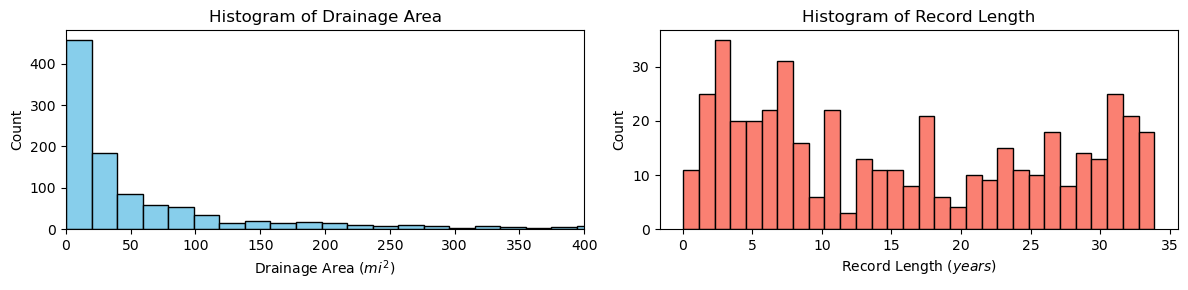

In [116]:
# plot the histogram of the stations' drainage area and their length of record
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Histogram for Drainage Area
axes[0].hist(nys_stations_dis[nys_stations_dis['drain_Area']<1000]['drain_Area'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title("Histogram of Drainage Area")
axes[0].set_xlabel("Drainage Area ($mi^2$)")
axes[0].set_ylabel("Count")
axes[0].set_xlim(0,400)
# Histogram for Record Length
axes[1].hist(nys_stations_dis['len_record'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title("Histogram of Record Length")
axes[1].set_xlabel("Record Length ($years$)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\USGS_Sta_dran_record_len_hist.png",
            dpi=300, bbox_inches='tight')
plt.show()


# Filter and show the representative catchments

In [117]:
# number of stations with less than 2 (mi^2) drainage area and more than 15 years of record 
count = nys_stations_dis[(nys_stations_dis['drain_Area'] < 2) & (nys_stations_dis['len_record'] > 15)].shape[0]
print (f'There are {count} stations with less than 2 (mi^2) drainage area and more than 15 years of record')

There are 6 stations with less than 2 (mi^2) drainage area and more than 15 years of record


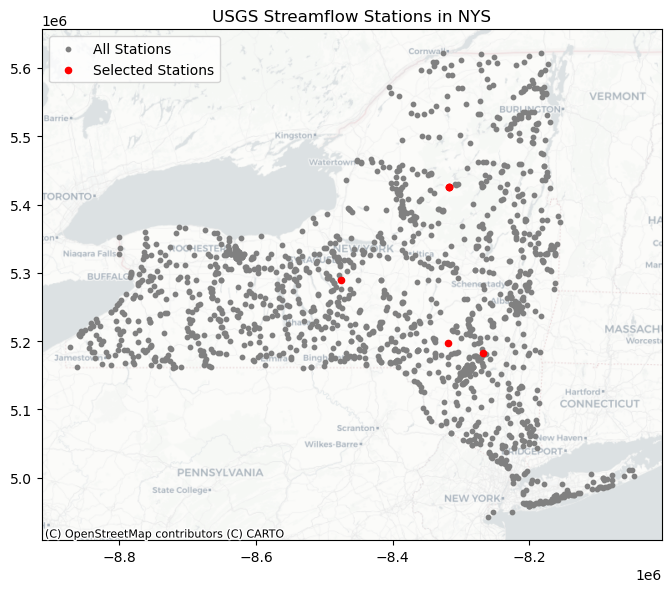

In [118]:
# Convert to GeoDataFrame using the existing 'geometry' column
gdf = gpd.GeoDataFrame(nys_stations_dis, geometry='geometry', crs="EPSG:4269")

# Filter stations of interest
highlighted = gdf[(gdf['drain_Area'] < 2) & (gdf['len_record'] > 15)]

# Reproject to Web Mercator for basemap
gdf_web = gdf.to_crs(epsg=3857)
highlighted_web = highlighted.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
gdf_web.plot(ax=ax, color='gray', markersize=10, label='All Stations')
highlighted_web.plot(ax=ax, color='red', markersize=20, label='Selected Stations')

# Annotate highlighted points with site_no
#for x, y, label in zip(highlighted_web.geometry.x, highlighted_web.geometry.y, highlighted_web['site_no']):
#    ax.text(x, y, str(label), fontsize=8, color='black', ha='right')

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.8)

ax.set_title("USGS Streamflow Stations in NYS")
ax.legend()
plt.savefig(r"D:\culvert repo\Results\Figures\selected_USGS_Sta_map.png",
            dpi=300, bbox_inches='tight')
plt.show()

# Calculate the $n-year$ discharge and its uncertainty

## Derivation of the 95% Confidence Interval 

### Step 0: Empirical Estimate of \( P \)

When we have \( N \) years of data and rank the annual maximum events from largest to smallest,  
the empirical exceedance probability \( P \) is estimated by:

$$
P = \frac{m}{N+1}
$$

where:
- \( m \) = rank of the event (1 = largest, 2 = second largest, etc.),
- \( N \) = number of years of data.

---

### Step 1: Standard Error of a Proportion

For a binomial proportion \( P \), the standard error (SE) is given by:

$$
\text{SE}(P) = \sqrt{ \frac{P(1 - P)}{N} }
$$

---

### Step 2: Normal Approximation to the Binomial

By the Central Limit Theorem, for large \( N \), the sampling distribution of \( P \) is approximately normal.  
Thus, the confidence interval can be constructed as:

$$
\text{CI} = P \pm z \cdot \text{SE}(P)
$$

where \( z \) is the z-score corresponding to the desired confidence level.  
For a 95% confidence interval:

$$
z = 1.96
$$

### Plot the timeseries and CDF of annual maxima dis and 2 and 5 year event

In [119]:
subset = nys_stations_dis[
    nys_stations_dis['site_no'].isin(['01362342', '01422389', '04253294', '04253296', '04253295'])
]
subset.site_no

364     01362342
514     01422389
1210    04253294
1211    04253295
1212    04253296
Name: site_no, dtype: object

In [120]:
['01362342', '01422389','04253294', '04253296', '04253295']

['01362342', '01422389', '04253294', '04253296', '04253295']

In [ ]:
site_no[0]

[ 32.   99.  156.  107.   63.   33.  102.   83.  360.  169.   83.  123.
  54.4 396.  487.  291.   48.4 263.   54.8 164.  158.  104.   74.1 456.
 151.  154.  224.  159.   67.3]


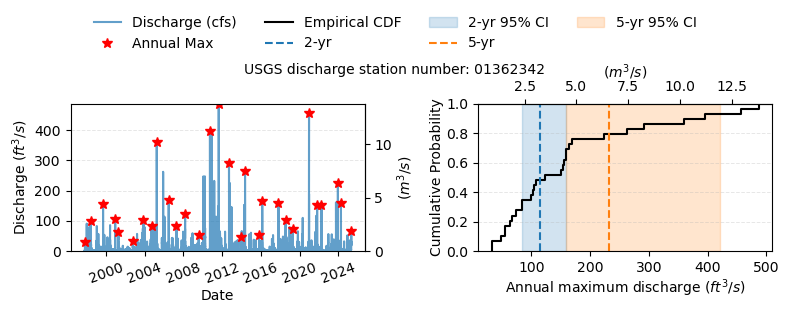

[ 3.1 21.  18.  15.  17.  15.  36.  30.  45.  39.  13.  30.  34. ]


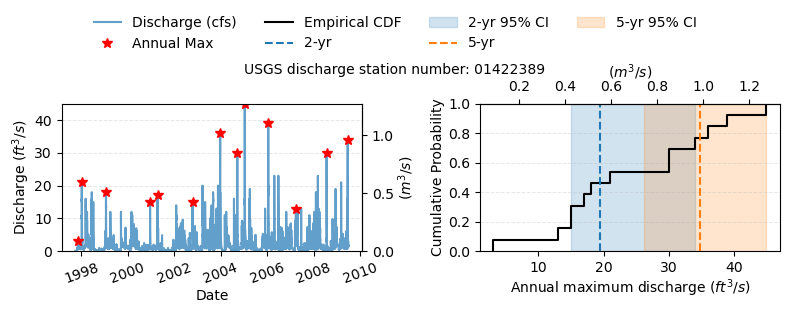

[ 3.4   6.66 47.   11.8  24.9   3.84  7.02 24.9   5.29  8.54  9.52  8.59
 18.9   9.41 77.5   8.2  20.6   5.93 20.9 ]


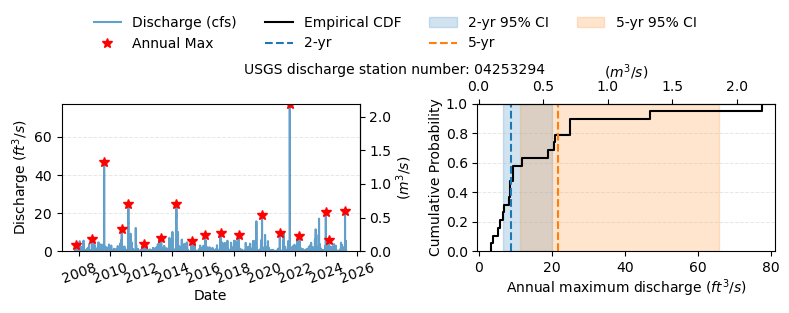

[ 2.89  3.47  2.56  5.59  7.48  1.92  5.9   1.99  1.58  1.87  4.56  3.15
 10.    5.13  9.56  3.71  9.01  3.09  7.93]


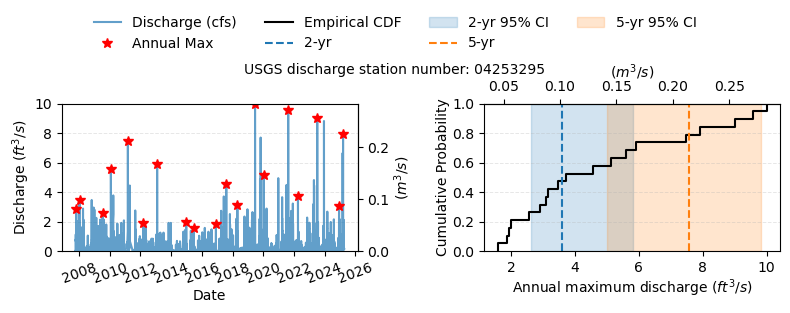

[ 48.2  46.1 163.  106.   70.9  73.4  83.2  75.9  33.1  66.2  76.8 102.
 123.   61.3 224.   39.6 108.   33.7 120. ]


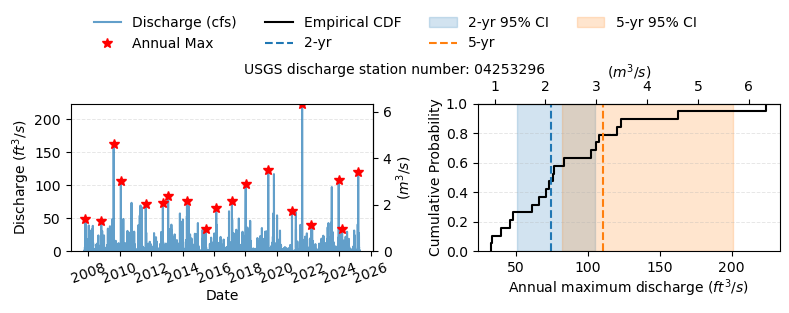

In [139]:
subset = nys_stations_dis[
    nys_stations_dis['site_no'].isin(['01362342', '01422389', '04253294', '04253296', '04253295'])
]
base_path = r'D:\culvert repo\data\USGS\discharge_NYS'
results = []  


factor = 0.0283168  # 1 ft³/s = 0.0283168 m³/s

def ft3s_to_m3s(q):
    return q * factor

def m3s_to_ft3s(q):
    return q / factor


for i, row in subset.iterrows():
    site_no = row.site_no
    path = os.path.join(base_path, f"{site_no}.csv")
    
    if not os.path.exists(path):
        print(f"File not found for site {site_no}, skipping...")
        continue
    
    try:
        site_result = {'site_no': site_no}
        # Read and clean data
        discharge = pd.read_csv(path, usecols=['datetime', '00060'])
        discharge['datetime'] = pd.to_datetime(discharge['datetime'])
        discharge = discharge.dropna(subset=['00060'])

        # Extract annual max
        discharge['year'] = discharge['datetime'].dt.year
        annual_max = discharge.loc[discharge.groupby('year')['00060'].idxmax()]
        annual_max = annual_max.dropna(subset=['00060'])
        max_values = annual_max['00060'].values

        

        # Set global font size for all elements
        plt.rcParams.update({
            'font.size': 10,       # Base font size
            'axes.titlesize': 10,  # Axes title font size
            'axes.labelsize': 10,  # X/Y label font size
            'xtick.labelsize': 10, # X tick labels
            'ytick.labelsize': 10, # Y tick labels
            'legend.fontsize': 10  # Legend font size
        })
        # plot
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))

        # Plot time series with annual maximum discharges
        axes[0].plot(discharge['datetime'], discharge['00060'], label='Discharge (cfs)', alpha=0.7)
        axes[0].plot(annual_max['datetime'], annual_max['00060'], 'r*', label='Annual Max', markersize=7)
        axes[0].set_ylim(0,np.max(max_values))
        #axes[0].set_title(f"Site {site_no}")
        axes[0].set_xlabel("Date",rotation=0, labelpad=2)
        axes[0].tick_params(axis='x', rotation=20)

        axes[0].set_ylabel("Discharge ($ft^3/s$)", labelpad=2)
        axes[0].grid(True, which='major',axis='y', linestyle='--', linewidth=0.7, alpha=0.3)
        #axes[0].legend(loc='upper left')
        # For the time series (subplot 0): secondary Y axis on the right
        secax0 = axes[0].secondary_yaxis('right', functions=(ft3s_to_m3s, m3s_to_ft3s))
        secax0.set_ylabel('($m^3/s$)', labelpad=2)
        # Plot CDFs
        # Empirical CDF
        ecdf = ECDF(max_values)
        inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error=False, fill_value="extrapolate")
        N = len(max_values)
        print(max_values)
        axes[1].step(ecdf.x, ecdf.y, where='post', label='Empirical CDF', color='black')
        # Return periods and exceedance probs
        return_periods = [2,5]
        #return_periods = [2]
        probabilities = [1-(1 / T) for T in return_periods]
        colors = ['tab:blue', 'tab:orange', 'tab:green']  # For 2-, 5-, 10-year lines

        for P, T, color in zip(probabilities, return_periods, colors):
            Q_T = inv_cdf(P)
            axes[1].axvline(Q_T, linestyle='--', color=color, label=f"{T}-yr")
        
            # 95% Confidence Interval
            SE = np.sqrt(P * (1 - P) / N)
            CI_low, CI_high = P - 1.96 * SE, P + 1.96 * SE
            CI_high = min(CI_high, 1)
            Q_low, Q_high = inv_cdf(CI_low), inv_cdf(CI_high)
        
            axes[1].fill_betweenx([0, 1], Q_low, Q_high, alpha=0.2, color=color, label=f"{T}-yr 95% CI")
        
            # Save to site_result with formatted column names
            site_result[f'lower_{T}_year'] = Q_low
            site_result[f'{T}_year'] = Q_T
            site_result[f'upper_{T}_year'] = Q_high

        
        #axes[1].set_title("Empirical CDF of annual maximum dishcharges")
        axes[1].set_xlabel("Annual maximum discharge ($ft^3/s$)", labelpad=2)
        axes[1].set_ylabel("Cumulative Probability", labelpad=2)
        axes[1].set_ylim(0,1)
        axes[1].grid(True, which='major',axis='y', linestyle='--', linewidth=0.7, alpha=0.3)
        #axes[1].legend(loc='lower right')
        # For the CDF (subplot 1): secondary X axis on the top
        secax1 = axes[1].secondary_xaxis('top', functions=(ft3s_to_m3s, m3s_to_ft3s))
        secax1.set_xlabel('($m^3/s$)', labelpad=2)
        # after plotting everything:
        handles0, labels0 = axes[0].get_legend_handles_labels()
        handles1, labels1 = axes[1].get_legend_handles_labels()

        # merge and drop duplicates while preserving order
        from collections import OrderedDict
        by_label = OrderedDict(zip(labels0 + labels1, handles0 + handles1))

        fig.legend(
            by_label.values(), by_label.keys(),
            loc='upper center',
            bbox_to_anchor=(0.5, 1.05),   # center above the subplots
            ncol=4,                       # number of columns (tweak for layout)
            frameon=True,
            fontsize=10
        )

        #plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space at top for legend
        fig.suptitle(f"USGS discharge station number: {site_no}", fontsize=10, y=0.85)
        
        # show
        plt.tight_layout()
        plt.savefig(rf'D:\culvert repo\Results\Figures\val_quantiles_{site_no}_paper.png', dpi=300)
        plt.show()
        results.append(site_result)
    
    except Exception as e:
        print(f"Error processing site {site_no}: {e}")
# save .csv
results_df = pd.DataFrame(results)
results_df.to_csv(r'D:\culvert repo\Results\Validation\discharge\val_discharge_CI_by_site_paper.csv', index=False)

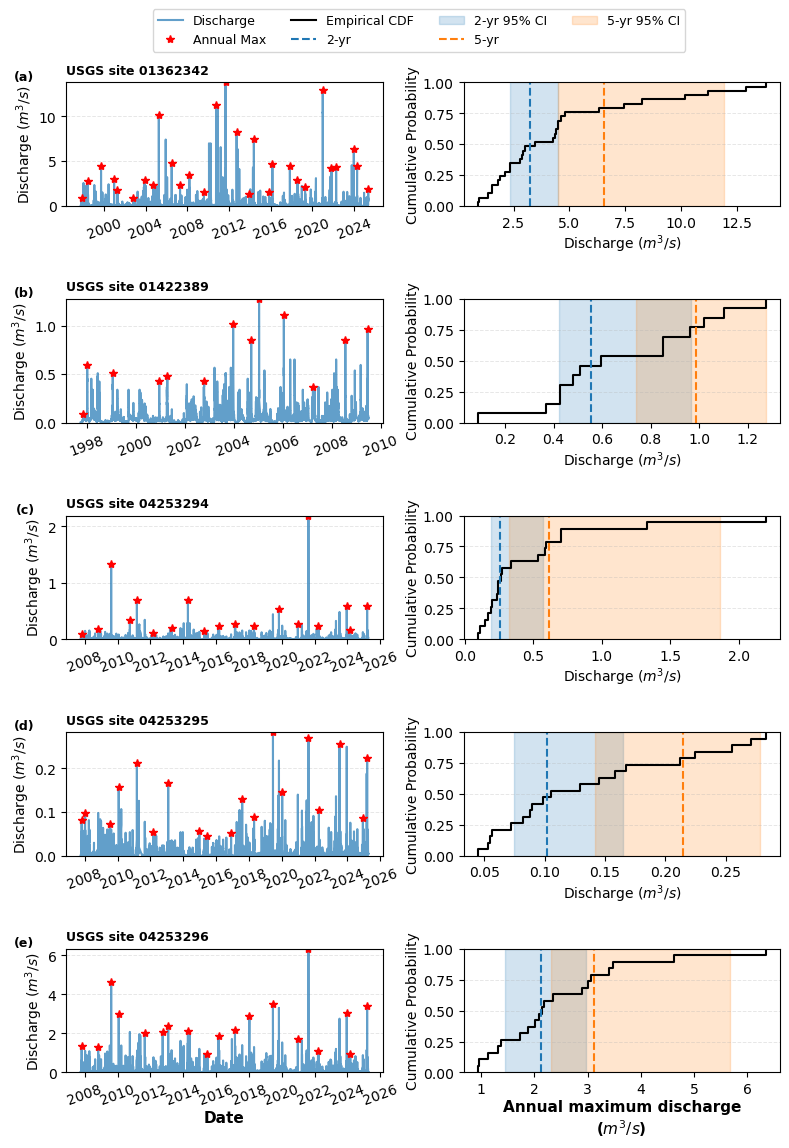

In [ ]:
nrows = len(site_list)
fig, axes = plt.subplots(nrows, 2, figsize=(8, 2.3*nrows), squeeze=False)

# collect legend only once
all_handles, all_labels = [], []

FT3S_TO_M3S = 0.0283168

for r, (site_no, path) in enumerate(site_list):
    discharge = pd.read_csv(path, usecols=['datetime', '00060'])
    discharge['datetime'] = pd.to_datetime(discharge['datetime'])
    discharge = discharge.dropna(subset=['00060'])

    # convert cfs → m³/s
    discharge['Q_m3s'] = discharge['00060'] * FT3S_TO_M3S
    discharge['year'] = discharge['datetime'].dt.year
    annual_max = discharge.loc[discharge.groupby('year')['Q_m3s'].idxmax()]
    max_values = annual_max['Q_m3s'].values
    N = len(max_values)

    ax_ts = axes[r, 0]
    ax_cdf = axes[r, 1]

    # --- time series (m³/s) ---
    ax_ts.plot(discharge['datetime'], discharge['Q_m3s'],
               label='Discharge', color='tab:blue', alpha=0.7)
    ax_ts.plot(annual_max['datetime'], annual_max['Q_m3s'],
               'r*', label='Annual Max', markersize=6)
    ax_ts.set_ylim(0, float(np.max(max_values)))
    if r == 4:
        ax_ts.set_xlabel("Date", fontsize=11, fontweight="bold", labelpad=2)
    ax_ts.tick_params(axis='x', rotation=20)
    ax_ts.set_ylabel("Discharge ($m^3/s$)", labelpad=2)
    ax_ts.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.3)
    ax_ts.set_title(f"USGS site {site_no}", fontsize=9, loc='left', weight='bold')

    # --- empirical CDF (m³/s) ---
    ecdf = ECDF(max_values)
    inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error=False, fill_value="extrapolate")

    ax_cdf.step(ecdf.x, ecdf.y, where='post', label='Empirical CDF', color='black')

    return_periods = [2, 5]
    probabilities = [1 - (1 / T) for T in return_periods]
    colors = ['tab:blue', 'tab:orange']

    for P, T, color in zip(probabilities, return_periods, colors):
        Q_T = inv_cdf(P)
        ax_cdf.axvline(Q_T, linestyle='--', color=color, label=f"{T}-yr")

        SE = np.sqrt(P * (1 - P) / N)
        CI_low, CI_high = P - 1.96*SE, min(P + 1.96*SE, 1)
        Q_low, Q_high = inv_cdf(CI_low), inv_cdf(CI_high)
        ax_cdf.fill_betweenx([0, 1], Q_low, Q_high, alpha=0.2,
                             color=color, label=f"{T}-yr 95% CI")

    if r == 4:
        ax_cdf.set_xlabel("Annual maximum discharge\n($m^3/s$)", 
                          fontsize=11, fontweight="bold", labelpad=2)
    else:
        ax_cdf.set_xlabel("Discharge ($m^3/s$)", labelpad=2)
    ax_cdf.set_ylabel("Cumulative Probability", labelpad=2)
    ax_cdf.set_ylim(0, 1)
    ax_cdf.grid(True, axis='y', linestyle='--', linewidth=0.7, alpha=0.3)

    # panel label (a), (b), ...
    panel_label = f"({string.ascii_lowercase[r]})"
    ax_ts.text(-0.1, 1.1, panel_label, transform=ax_ts.transAxes,
               fontsize=9, fontweight='bold', va='top', ha='right')

    # collect legend entries from the first row only
    if r == 0:
        h0, l0 = ax_ts.get_legend_handles_labels()
        h1, l1 = ax_cdf.get_legend_handles_labels()
        all_handles, all_labels = h0+h1, l0+l1

# --- combined legend ---
by_label = OrderedDict(zip(all_labels, all_handles))
fig.legend(by_label.values(), by_label.keys(),
           loc='upper center', bbox_to_anchor=(0.53, 1),
           ncol=4, fontsize=9, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.75)   # tighten row spacing

plt.savefig(r"D:\culvert repo\Results\Figures\val_quantiles_ALL_sites_pubready.png",
            dpi=600, bbox_inches='tight')

plt.show()


### paper plot

In [140]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

# subset of sites
subset = nys_stations_dis[
    nys_stations_dis['site_no'].isin(['01362342', '01422389', '04253294', '04253296', '04253295'])
].copy()

base_path = r'D:\culvert repo\data\USGS\discharge_NYS'
results = []

if subset.empty:
    raise ValueError("Subset is empty. Check your site_no list or input dataframe.")

# Global font sizes (bigger everywhere)
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 13
})

n_rows = len(subset)
fig_h = 3.6 * n_rows  # height per row
fig_w = 14
fig, axes = plt.subplots(n_rows, 2, figsize=(fig_w, fig_h), squeeze=False)

return_periods = [2, 5]
probabilities = [1 - (1 / T) for T in return_periods]
colors = ['tab:blue', 'tab:orange']  # match number of return periods

for r, (_, row) in enumerate(subset.iterrows()):
    site_no = row.site_no
    path = os.path.join(base_path, f"{site_no}.csv")

    if not os.path.exists(path):
        print(f"File not found for site {site_no}, skipping...")
        continue

    try:
        site_result = {'site_no': site_no}

        # Read and clean data
        discharge = pd.read_csv(path, usecols=['datetime', '00060'])
        discharge['datetime'] = pd.to_datetime(discharge['datetime'])
        discharge = discharge.dropna(subset=['00060'])

        # Extract annual max
        discharge['year'] = discharge['datetime'].dt.year
        annual_max = discharge.loc[discharge.groupby('year')['00060'].idxmax()].dropna(subset=['00060'])
        max_values = annual_max['00060'].values

        # Skip if too few points
        if len(max_values) < 5:
            print(f"Not enough annual maxima for site {site_no}, skipping...")
            continue

        ax_ts = axes[r, 0]
        ax_cdf = axes[r, 1]

        # Time series plot
        ax_ts.plot(discharge['datetime'], discharge['00060'], label='Discharge (cfs)', alpha=0.7)
        ax_ts.plot(annual_max['datetime'], annual_max['00060'], 'r*', label='Annual Max', markersize=8)
        ax_ts.set_ylim(0, np.max(max_values))
        ax_ts.set_xlabel("Date")
        ax_ts.set_ylabel("Discharge ($cfs$)")
        ax_ts.grid(True)
        ax_ts.legend(loc='upper left')
        # Row title centered over both panels
        ax_ts.set_title(f"Site {site_no}", pad=6)

        # Empirical CDF
        ecdf = ECDF(max_values)
        inv_cdf = interp1d(ecdf.y, ecdf.x, bounds_error=False, fill_value="extrapolate")
        N = len(max_values)

        ax_cdf.step(ecdf.x, ecdf.y, where='post', label='Empirical CDF', color='black')

        for P, T, color in zip(probabilities, return_periods, colors):
            Q_T = inv_cdf(P)
            ax_cdf.axvline(Q_T, linestyle='--', color=color, label=f"{T}-yr: {Q_T:.1f} cfs")

            # 95% CI in probability space, then invert
            SE = np.sqrt(P * (1 - P) / N)
            CI_low, CI_high = P - 1.96 * SE, P + 1.96 * SE
            CI_low = max(0.0, CI_low)
            CI_high = min(1.0, CI_high)

            Q_low, Q_high = inv_cdf(CI_low), inv_cdf(CI_high)
            ax_cdf.fill_betweenx([0, 1], Q_low, Q_high, alpha=0.2, color=color, label=f"{T}-yr 95% CI")

            # Save results
            site_result[f'lower_{T}_year'] = float(Q_low)
            site_result[f'{T}_year'] = float(Q_T)
            site_result[f'upper_{T}_year'] = float(Q_high)

        ax_cdf.set_xlabel("Discharge ($cfs$)")
        ax_cdf.set_ylabel("Cumulative Probability")
        ax_cdf.set_ylim(0, 1)
        ax_cdf.grid(True)
        ax_cdf.legend(loc='lower right')

        results.append(site_result)

    except Exception as e:
        print(f"Error processing site {site_no}: {e}")

# Overall figure title (optional)
#fig.suptitle("Annual-Max Discharge and Empirical CDF by Site", y=0.995, fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.98])
out_png = r'D:\culvert repo\Results\Figures\val_quantiles_ALL_SITES.png'
plt.savefig(out_png, dpi=300)
plt.close(fig)
print(f"Saved figure to: {out_png}")


Saved figure to: D:\culvert repo\Results\Figures\val_quantiles_ALL_SITES.png


# Read the empirical, NRCS, and streamstats estimation of the quantiles

In [3]:
path=r"D:\culvert repo\Results\Validation\discharge\val_discharge_streanstats_NRCS_LL_UP.csv"
dis=pd.read_csv(path)
#dis = dis.drop(index=4)  
dis.head()

,BIN,Q_LL_2,Q_2,Q_UL_2,Q_LL_5,Q_5,Q_UL_5,site_no,lower_2_year,2_year,upper_2_year,lower_5_year,5_year,upper_5_year,Str_stat_2_year,Str_stat_5_year
0,1362342,61.394391,118.858726,411.023599,126.307745,218.036346,668.570236,1362342,83.000000,115.00,158.777461,157.956062,231.80,421.318152,170.00,308.0
1,1422389,16.799149,34.472046,88.236194,41.157593,72.500119,158.824960,1422389,14.933120,19.50,34.066881,26.159230,34.80,45.000000,76.00,121.0
2,4253294,3.651239,16.795324,44.278840,15.911801,36.648886,80.652106,4253294,6.742180,9.00,20.211926,11.304381,21.70,65.829992,8.98,13.2
3,4253296,5.611869,32.286033,82.203539,24.531272,68.863787,140.681455,4253296,51.190455,74.65,105.086884,81.808789,110.40,200.659983,44.60,65.0
4,4253295,0.322286,2.009731,5.348275,2.616335,3.354006,11.175090,4253295,2.635332,3.59,5.829233,5.006095,7.57,9.831646,6.93,10.1


In [4]:
# streamstats standard error (percent)
dis['dis_std_error_2_strstat'] = [23.6, 27.9,29, 29, 29]
dis['dis_std_error_5_strstat'] = [24.7, 20.4,27.3, 27.3, 27.3]

In [5]:
# Compute Empirical CI error bars
error_2yr = [
    dis['2_year'] - dis['lower_2_year'],
    dis['upper_2_year'] - dis['2_year']
]

error_5yr = [
    dis['5_year'] - dis['lower_5_year'],
    dis['upper_5_year'] - dis['5_year']
]

In [6]:
sites=dis['BIN']

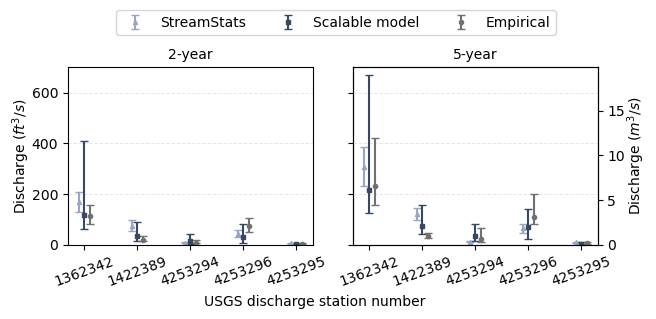

In [165]:
# Conversion factor
factor = 0.0283168  # 1 ft³/s = 0.0283168 m³/s

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
offset = 0.1

# ----- 2-Year Plot -----
axes[0].errorbar(
    x - offset, dis['Str_stat_2_year'],
    yerr=ss_error_2yr,
    fmt='^', color='#97a6c4', ecolor='#97a6c4', capsize=3,
    markersize=3,label='Streamstats'
)
axes[0].errorbar(
    x, dis['Q_2'],
    yerr=nrcs_error_2yr,
    fmt='s', color='#384860', ecolor='#384860', capsize=3,
    markersize=3,label='Scalable model'
)
axes[0].errorbar(
    x + offset, dis['2_year'],
    yerr=error_2yr,
    fmt='o', color='#707070', ecolor='#707070', capsize=3,
    markersize=3,label='Empirical'
)
axes[0].set_title('2-year')
#axes[0].set_xlabel('USGS discharge station number',labelpad=0)
axes[0].set_ylabel('Discharge ($ft^3/s$)',labelpad=0)
axes[0].set_xticks(x)
axes[0].set_xticklabels(sites, rotation=20)
axes[0].set_ylim(0,700 )

axes[0].grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)

# ----- 5-Year Plot -----
axes[1].errorbar(
    x - offset, dis['Str_stat_5_year'],
    yerr=ss_error_5yr,
    fmt='^', color='#97a6c4', ecolor='#97a6c4', capsize=3,
    markersize=3,label='StreamStats'
)
axes[1].errorbar(
    x, dis['Q_5'],
    yerr=nrcs_error_5yr,
    fmt='s', color='#384860', ecolor='#384860', capsize=3,
    markersize=3,label='Scalable model'
)
axes[1].errorbar(
    x + offset, dis['5_year'],
    yerr=error_5yr,
    fmt='o', color='#707070', ecolor='#707070', capsize=3,
    markersize=3,label='Empirical'
)
axes[1].set_title('5-year')
#axes[1].set_xlabel('USGS discharge station number',labelpad=0)
axes[1].set_xticks(x)
axes[1].set_xticklabels(sites, rotation=20)
axes[1].grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)

# Twin axis (m³/s) for subplot 1
ax2_1 = axes[1].twinx()
ax2_1.set_ylabel('Discharge ($m^3/s$)', fontsize=10, labelpad=0)
ymin, ymax = axes[1].get_ylim()
ax2_1.set_ylim(ymin * factor, ymax * factor)

# Legend outside figure
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    fontsize=10, bbox_to_anchor=(0.71,1.1), loc='upper right', ncol=3, frameon=True
)
fig.supxlabel('USGS discharge station number', fontsize=10, x=0.40,y=0.08)

plt.tight_layout(rect=[0,0,0.85,1])  # leave space for legend
plt.savefig(r"D:\culvert repo\Results\Figures\2_and_5_year_evnet_stream_NRCS_emprical.png",
            dpi=300, bbox_inches='tight')
plt.show()


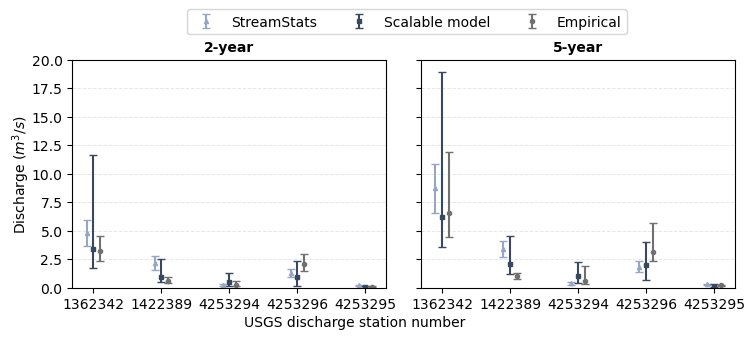

In [191]:
# Conversion factor
factor = 0.0283168  # 1 ft³/s = 0.0283168 m³/s

# Convert discharge values to m³/s
dis_m3s = dis.copy()
for col in ['Str_stat_2_year','Q_2','2_year',
            'Str_stat_5_year','Q_5','5_year']:
    dis_m3s[col] = dis_m3s[col] * factor

# Convert error bands too
ss_error_2yr_m3s   = np.array(ss_error_2yr)   * factor
nrcs_error_2yr_m3s = np.array(nrcs_error_2yr) * factor
error_2yr_m3s      = np.array(error_2yr)      * factor

ss_error_5yr_m3s   = np.array(ss_error_5yr)   * factor
nrcs_error_5yr_m3s = np.array(nrcs_error_5yr) * factor
error_5yr_m3s      = np.array(error_5yr)      * factor

# ---------------- Plotting ----------------
fig, axes = plt.subplots(1, 2, figsize=(9, 3.3), sharey=True)
offset = 0.1

# ----- 2-Year Plot -----
axes[0].errorbar(
    x - offset, dis_m3s['Str_stat_2_year'],
    yerr=ss_error_2yr_m3s,
    fmt='^', color='#97a6c4', ecolor='#97a6c4', capsize=3,
    markersize=3, label='Streamstats'
)
axes[0].errorbar(
    x, dis_m3s['Q_2'],
    yerr=nrcs_error_2yr_m3s,
    fmt='s', color='#384860', ecolor='#384860', capsize=3,
    markersize=3, label='Scalable model'
)
axes[0].errorbar(
    x + offset, dis_m3s['2_year'],
    yerr=error_2yr_m3s,
    fmt='o', color='#707070', ecolor='#707070', capsize=3,
    markersize=3, label='Empirical'
)
axes[0].set_title('2-year',fontweight="bold")
axes[0].set_ylabel('Discharge ($m^3/s$)', labelpad=0)
axes[0].set_xticks(x)
axes[0].set_xticklabels(sites, rotation=0)
axes[0].grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)
axes[0].set_ylim(0,20)

# ----- 5-Year Plot -----
axes[1].errorbar(
    x - offset, dis_m3s['Str_stat_5_year'],
    yerr=ss_error_5yr_m3s,
    fmt='^', color='#97a6c4', ecolor='#97a6c4', capsize=3,
    markersize=3, label='StreamStats'
)
axes[1].errorbar(
    x, dis_m3s['Q_5'],
    yerr=nrcs_error_5yr_m3s,
    fmt='s', color='#384860', ecolor='#384860', capsize=3,
    markersize=3, label='Scalable model'
)
axes[1].errorbar(
    x + offset, dis_m3s['5_year'],
    yerr=error_5yr_m3s,
    fmt='o', color='#707070', ecolor='#707070', capsize=3,
    markersize=3, label='Empirical'
)
axes[1].set_title('5-year',fontweight="bold")
axes[1].set_xticks(x)
axes[1].set_xticklabels(sites, rotation=0)
axes[1].grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)

# Legend outside figure
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    fontsize=10, bbox_to_anchor=(0.71,1.07), loc='upper right', ncol=3, frameon=True
)
fig.supxlabel('USGS discharge station number', fontsize=10, x=0.40,y=0.08)

plt.tight_layout(rect=[0,0,0.85,1])  # leave space for legend
plt.savefig(r"D:\culvert repo\Results\Figures\2_and_5_year_event_stream_NRCS_empirical_m3s.png",
            dpi=300, bbox_inches='tight')
plt.show()


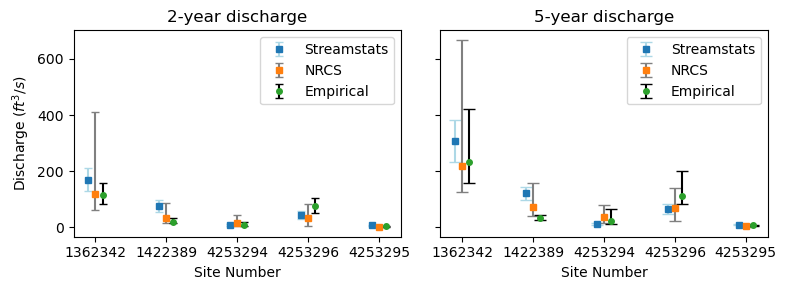

In [62]:
# Compute NRCS error bars
nrcs_error_2yr = [
    dis['Q_2'] - dis['Q_LL_2'],
    dis['Q_UL_2'] - dis['Q_2']
]

nrcs_error_5yr = [
    dis['Q_5'] - dis['Q_LL_5'],
    dis['Q_UL_5'] - dis['Q_5']
]
x = np.arange(len(dis))
# Compute StreamStats CI (95% CI assumed from percent error)
ss_error_2yr = dis['Str_stat_2_year'] * dis['dis_std_error_2_strstat'] / 100
ss_error_5yr = dis['Str_stat_5_year'] * dis['dis_std_error_5_strstat'] / 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
offset = 0.1

# ----- 2-Year Plot -----
axes[0].errorbar(
    x - offset, dis['Str_stat_2_year'],
    yerr=ss_error_2yr,
    fmt='s', color='tab:blue', ecolor='lightblue', capsize=3,
    markersize=4,label='Streamstats'
)
axes[0].errorbar(
    x, dis['Q_2'],
    yerr=nrcs_error_2yr,
    fmt='s', color='tab:orange', ecolor='gray', capsize=3,
    markersize=4,label='NRCS'
)
axes[0].errorbar(
    x + offset, dis['2_year'],
    yerr=error_2yr,
    fmt='o', color='tab:green', ecolor='black', capsize=3,
    markersize=4,label='Empirical'
)
axes[0].set_title('2-year discharge')
axes[0].set_xlabel('Site Number')
axes[0].set_ylabel('Discharge ($ft^3/s$)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(sites, rotation=0)
axes[0].legend(loc='upper right')

# ----- 5-Year Plot -----
axes[1].errorbar(
    x - offset, dis['Str_stat_5_year'],
    yerr=ss_error_5yr,
    fmt='s', color='tab:blue', ecolor='lightblue', capsize=4,
    markersize=4,label='Streamstats'
)
axes[1].errorbar(
    x, dis['Q_5'],
    yerr=nrcs_error_5yr,
    fmt='s', color='tab:orange', ecolor='gray', capsize=4,
    markersize=4,label='NRCS'
)
axes[1].errorbar(
    x + offset, dis['5_year'],
    yerr=error_5yr,
    fmt='o', color='tab:green', ecolor='black', capsize=4,
    markersize=4,label='Empirical'
)
axes[1].set_title('5-year discharge')
axes[1].set_xlabel('Site Number')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sites, rotation=0)
axes[1].legend(loc='upper right')
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\2_and_5_year_evnet_stream_NRCS_emprical_paper.png",
            dpi=300, bbox_inches='tight')
plt.show()

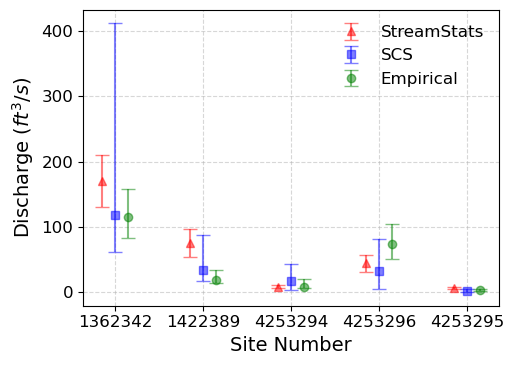

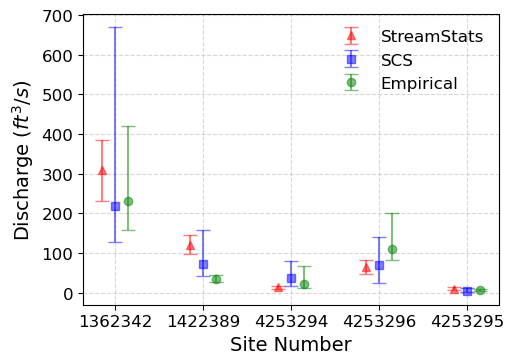

In [57]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(dis))
offset = 0.15
marker_size = 6
capsize = 5
font_title = 16
font_label = 14
font_tick = 12
font_legend = 12

# --- NRCS error bars ---
nrcs_error_2yr = [dis['Q_2'] - dis['Q_LL_2'], dis['Q_UL_2'] - dis['Q_2']]
nrcs_error_5yr = [dis['Q_5'] - dis['Q_LL_5'], dis['Q_UL_5'] - dis['Q_5']]

# --- StreamStats error ---
ss_error_2yr = dis['Str_stat_2_year'] * dis['dis_std_error_2_strstat'] / 100
ss_error_5yr = dis['Str_stat_5_year'] * dis['dis_std_error_5_strstat'] / 100

# ===================== 2-YEAR PLOT =====================
fig, ax1 = plt.subplots(figsize=(7*0.75, 5*0.75))

# StreamStats: red triangle
ax1.errorbar(
    x - offset, dis['Str_stat_2_year'],
    yerr=ss_error_2yr,
    fmt='^', color='red', ecolor='red', capsize=capsize,
    alpha=0.5, markersize=marker_size, label='StreamStats'
)

# NRCS: blue square
ax1.errorbar(
    x, dis['Q_2'],
    yerr=nrcs_error_2yr,
    fmt='s', color='blue', ecolor='blue', capsize=capsize,
    alpha=0.5, markersize=marker_size, label='SCS'
)

# Empirical: green circle
ax1.errorbar(
    x + offset, dis['2_year'],
    yerr=error_2yr,
    fmt='o', color='green', ecolor='green', capsize=capsize,
    alpha=0.5, markersize=marker_size, label='Empirical'
)

#ax1.set_title('2-Year Discharge Estimates', fontsize=font_title)
ax1.set_xlabel('Site Number', fontsize=font_label)
ax1.set_ylabel('Discharge ($ft^3/s$)', fontsize=font_label)
ax1.set_xticks(x)
ax1.set_xticklabels(sites, fontsize=font_tick)
ax1.tick_params(axis='y', labelsize=font_tick)
ax1.legend(loc='upper right', frameon=False, fontsize=font_legend)
ax1.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\2_year_discharge_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# ===================== 5-YEAR PLOT =====================
fig, ax2 = plt.subplots(figsize=(7*0.75, 5*0.75))

# StreamStats: red triangle
ax2.errorbar(
    x - offset, dis['Str_stat_5_year'],
    yerr=ss_error_5yr,
    fmt='^', color='red', ecolor='red', capsize=capsize,
    alpha=0.5, markersize=marker_size, label='StreamStats'
)

# NRCS: blue square
ax2.errorbar(
    x, dis['Q_5'],
    yerr=nrcs_error_5yr,
    fmt='s', color='blue', ecolor='blue', capsize=capsize,
    alpha=0.5, markersize=marker_size, label='SCS'
)

# Empirical: green circle
ax2.errorbar(
    x + offset, dis['5_year'],
    yerr=error_5yr,
    fmt='o', color='green', ecolor='green', capsize=capsize,
    alpha=0.5, markersize=marker_size, label='Empirical'
)

#ax2.set_title('5-Year Discharge Estimates', fontsize=font_title)
ax2.set_xlabel('Site Number', fontsize=font_label)
ax2.set_ylabel('Discharge ($ft^3/s$)', fontsize=font_label)
ax2.set_xticks(x)
ax2.set_xticklabels(sites, fontsize=font_tick)
ax2.tick_params(axis='y', labelsize=font_tick)
ax2.legend(loc='upper right', frameon=False, fontsize=font_legend)
ax2.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(r"D:\culvert repo\Results\Figures\5_year_discharge_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [58]:
# ----- 2-Year -----
r2_streamstats_2yr = r2_score(dis['2_year'], dis['Str_stat_2_year'])
r2_nrcs_2yr = r2_score(dis['2_year'], dis['Q_2'])

# ----- 5-Year -----
r2_streamstats_5yr = r2_score(dis['5_year'], dis['Str_stat_5_year'])
r2_nrcs_5yr = r2_score(dis['5_year'], dis['Q_5'])

print(f"2-Year StreamStats: {r2_streamstats_2yr:.2f}")
print(f"2-Year SCS (NRCS):  {r2_nrcs_2yr:.2f}")
print(f"5-Year StreamStats: {r2_streamstats_5yr:.2f}")
print(f"5-Year SCS (NRCS):  {r2_nrcs_5yr:.2f}")

2-Year StreamStats: 0.24
2-Year SCS (NRCS):  0.78
5-Year StreamStats: 0.56
5-Year SCS (NRCS):  0.90


In [59]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-07-25 15:51:41.224588


In [60]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,geopandas,matplotlib,seaborn,os,rasterio,tqdm,scipy,statsmodels

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy      : 2.0.2
pandas     : 2.2.2
geopandas  : 1.0.1
matplotlib : 3.8.4
seaborn    : 0.13.2
os         : unknown
rasterio   : 1.4.3
tqdm       : 4.66.5
scipy      : 1.13.1
statsmodels: 0.14.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

